# Adam Trentowski - 162602 - Machine Learning
## lab_07
## Library Imports

In [28]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

In [4]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
vlagun_phys = pd.read_csv('VLagun_Phys_Years3.csv')
vlagun_phys.head()

,PSU,O2,temp.,SS,DOC,TPOC,Windspeedinsitu,Depth,Years
0,3.757624,9.46,18.3,52.0,7.500,8.5650,3.5,3.3,0
1,3.504707,9.89,19.1,50.0,7.860,8.5200,0.0,3.6,0
2,3.757624,9.66,18.1,59.0,8.172,8.4915,1.0,3.4,0
3,3.107266,10.36,19.5,46.0,7.848,8.8320,0.0,2.9,0
4,2.619498,11.56,19.0,42.0,7.536,9.2400,0.0,3.0,0


In [55]:
vlagun_total = pd.read_csv('VLagun_Total_Basins_35.csv')
vlagun_total.head()

,Unnamed: 0,PSU,O2,temp.,SS,SRP,DOP,PP,NH4N,NO3N,...,Acartia tonsa,Eurytemora affinis,Cyclops sp.,Nauplii Cyclopoida,Nauplii Calanoida,Filinia longiseta,Keratella cochlearis cochlearis,Keratella cochlearis f.tecta,Keratella quadrata,Basin
0,17.06.2008_1,3.757624,9.46,18.3,52.0,3.5,11.7,185.0,0.039,0.022,...,0.9298,0.9251,0.0000,0.0025,0.0257,1.3152,0.8920,0.2714,0.0000,0
1,17.06.2008_2,3.504707,9.89,19.1,50.0,4.4,17.5,111.3,0.020,0.025,...,0.0378,0.0000,0.0000,0.0000,0.0000,0.0769,0.0640,0.0464,0.0000,0
2,17.06.2008_9,3.721493,9.63,17.5,62.0,11.7,13.0,117.6,0.036,0.021,...,0.0000,0.0000,0.0093,0.0138,0.0006,0.0466,0.0120,0.0044,0.0000,0
3,17.06.2008_10,4.407982,9.54,18.4,55.0,7.4,16.2,124.7,0.023,0.024,...,0.0000,0.0129,0.0060,0.0140,0.0155,0.0313,0.0079,0.0040,0.0000,0
4,17.06.2008_11,4.389916,9.34,17.8,53.0,13.8,21.4,84.4,0.031,0.030,...,0.0000,0.0141,0.0000,0.0093,0.0007,0.0491,0.0143,0.0019,0.0026,0


## Data splitting

In [8]:
seed = 7
test_size = 0.20

In [9]:
X_diabetes = diabetes.iloc[:, :-1].values
Y_diabetes = diabetes.iloc[:, -1].values

X_train_diabetes, X_test_diabetes, Y_train_diabetes, Y_test_diabetes = train_test_split(X_diabetes, Y_diabetes, test_size=test_size, random_state=seed)

print("X_train_diabetes shape:", X_train_diabetes.shape)
print("X_test_diabetes shape:", X_test_diabetes.shape)

X_train_diabetes shape: (614, 8)
X_test_diabetes shape: (154, 8)


In [10]:
X_vlagun_phys = vlagun_phys.iloc[:, :-1].values
Y_vlagun_phys = vlagun_phys.iloc[:, -1].values

X_train_vlagun_phys, X_test_vlagun_phys, Y_train_vlagun_phys, Y_test_vlagun_phys = train_test_split(X_vlagun_phys, Y_vlagun_phys, test_size=test_size, random_state=seed)

print("X_train_vlagun_phys shape:", X_train_vlagun_phys.shape)
print("X_test_vlagun_phys shape:", X_test_vlagun_phys.shape)

X_train_vlagun_phys shape: (96, 8)
X_test_vlagun_phys shape: (24, 8)


In [56]:
vlagun_total.drop(columns=['Unnamed: 0'], inplace=True)

In [57]:
X_vlagun_total = vlagun_total.iloc[:, :-1].values
Y_vlagun_total = vlagun_total.iloc[:, -1].values

X_train_vlagun_total, X_test_vlagun_total, Y_train_vlagun_total, Y_test_vlagun_total = train_test_split(X_vlagun_total, Y_vlagun_total, test_size=test_size, random_state=seed)

print("X_train_vlagun_total shape:", X_train_vlagun_total.shape)
print("X_test_vlagun_total shape:", X_test_vlagun_total.shape)

X_train_vlagun_total shape: (124, 35)
X_test_vlagun_total shape: (31, 35)


## Confusion Matrix Function

In [12]:
def confusion_mat(Y_pred, Y_test, dataset_name):
    plt.figure()
    sns.set(font_scale=1.5)
    cm = confusion_matrix(Y_pred, Y_test)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f'Confusion matrix - {dataset_name}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Diabetes
### AdaBoost

In [35]:
clf = AdaBoostClassifier(n_estimators=100, random_state=1)
clf.fit(X_train_diabetes, Y_train_diabetes)

train_predicted = clf.predict(X_train_diabetes)
train_accuracy = np.mean(train_predicted == Y_train_diabetes)

test_predicted = clf.predict(X_test_diabetes)
test_accuracy = np.mean(test_predicted == Y_test_diabetes)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 0.7899
Test Accuracy of the result is: 0.7922


### Plot the confusion matrix

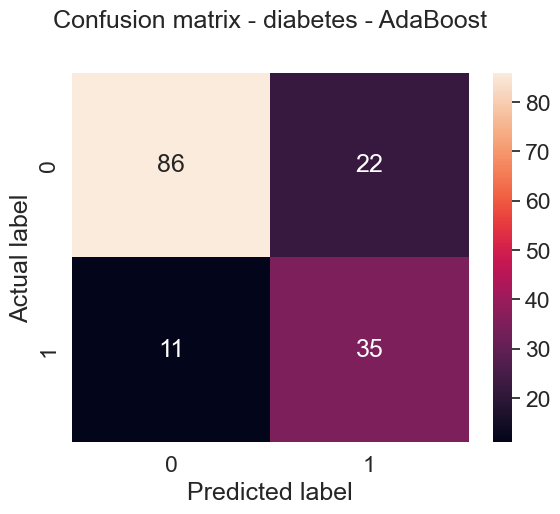

In [19]:
Y_pred = clf.predict(X_test_diabetes)
confusion_mat(Y_pred, Y_test_diabetes, "diabetes - AdaBoost")

### GradientBoost

In [36]:
clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_diabetes, Y_train_diabetes)

train_predicted = clf.predict(X_train_diabetes)
train_accuracy = np.mean(train_predicted == Y_train_diabetes)

test_predicted = clf.predict(X_test_diabetes)
test_accuracy = np.mean(test_predicted == Y_test_diabetes)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 0.9218
Test Accuracy of the result is: 0.7857


### Plot the confusion matrix

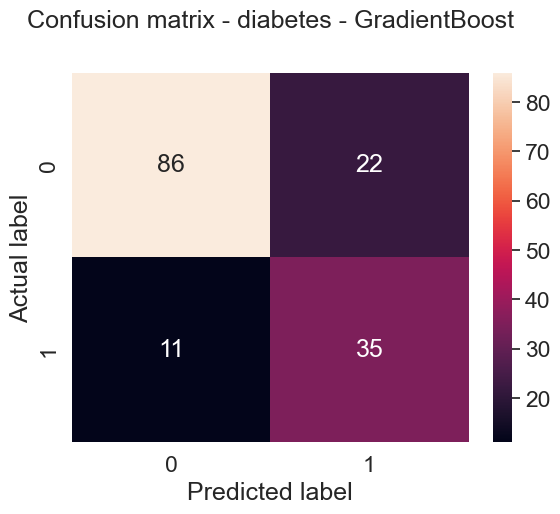

In [20]:
Y_pred = clf.predict(X_test_diabetes)
confusion_mat(Y_pred, Y_test_diabetes, "diabetes - GradientBoost")

### XGBoost

In [37]:
clf = XGBClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_diabetes, Y_train_diabetes)

train_predicted = clf.predict(X_train_diabetes)
train_accuracy = np.mean(train_predicted == Y_train_diabetes)

test_predicted = clf.predict(X_test_diabetes)
test_accuracy = np.mean(test_predicted == Y_test_diabetes)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 1.0000
Test Accuracy of the result is: 0.7532


### Plot the confusion matrix

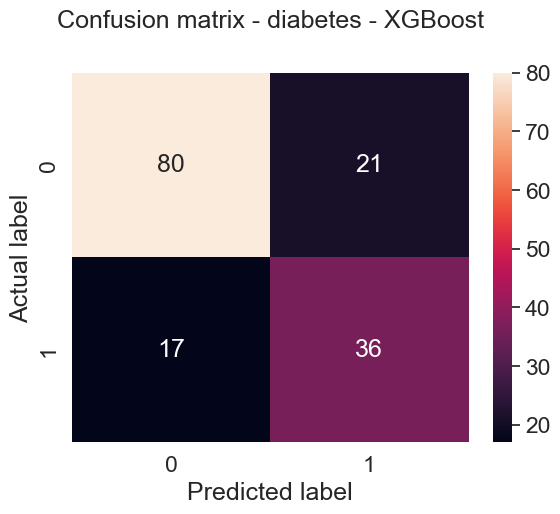

In [23]:
Y_pred = clf.predict(X_test_diabetes)
confusion_mat(Y_pred, Y_test_diabetes, "diabetes - XGBoost")

### Light GMB

In [38]:
clf = lgb.LGBMClassifier()
clf.fit(X_train_diabetes, Y_train_diabetes)

train_predicted = clf.predict(X_train_diabetes)
train_accuracy = np.mean(train_predicted == Y_train_diabetes)

test_predicted = clf.predict(X_test_diabetes)
test_accuracy = np.mean(test_predicted == Y_test_diabetes)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

[LightGBM] [Info] Number of positive: 211, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343648 -> initscore=-0.647078
[LightGBM] [Info] Start training from score -0.647078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Plot the confusion matrix

C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


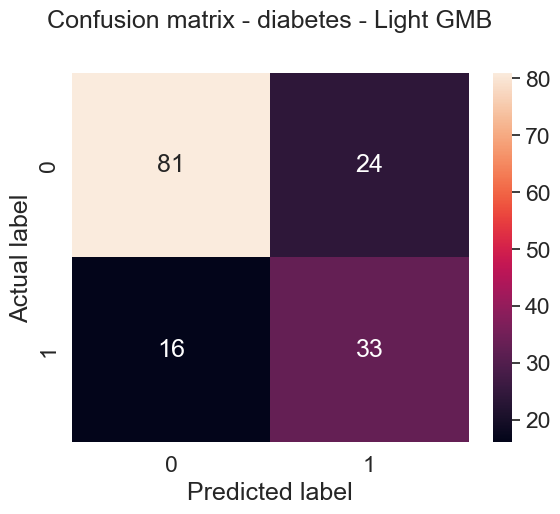

In [27]:
Y_pred = clf.predict(X_test_diabetes)
confusion_mat(Y_pred, Y_test_diabetes, "diabetes - Light GMB")

## CatBoost

In [39]:
clf = CatBoostClassifier(iterations=100)
clf.fit(X_train_diabetes, Y_train_diabetes)

train_predicted = clf.predict(X_train_diabetes)
train_accuracy = np.mean(train_predicted == Y_train_diabetes)

test_predicted = clf.predict(X_test_diabetes)
test_accuracy = np.mean(test_predicted == Y_test_diabetes)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Learning rate set to 0.069101
0:	learn: 0.6760666	total: 25.4ms	remaining: 2.52s
1:	learn: 0.6609943	total: 44.3ms	remaining: 2.17s
2:	learn: 0.6459697	total: 66.4ms	remaining: 2.15s
3:	learn: 0.6323207	total: 110ms	remaining: 2.64s
4:	learn: 0.6204131	total: 130ms	remaining: 2.46s
5:	learn: 0.6091624	total: 138ms	remaining: 2.17s
6:	learn: 0.5985349	total: 143ms	remaining: 1.9s
7:	learn: 0.5892854	total: 151ms	remaining: 1.74s
8:	learn: 0.5797280	total: 157ms	remaining: 1.59s
9:	learn: 0.5720928	total: 161ms	remaining: 1.44s
10:	learn: 0.5633238	total: 164ms	remaining: 1.33s
11:	learn: 0.5561125	total: 168ms	remaining: 1.23s
12:	learn: 0.5492857	total: 171ms	remaining: 1.15s
13:	learn: 0.5407571	total: 175ms	remaining: 1.07s
14:	learn: 0.5349191	total: 183ms	remaining: 1.04s
15:	learn: 0.5275887	total: 188ms	remaining: 986ms
16:	learn: 0.5214441	total: 193ms	remaining: 943ms
17:	learn: 0.5162823	total: 196ms	remaining: 891ms
18:	learn: 0.5107739	total: 199ms	remaining: 849ms
19:	learn

### Plot the confusion matrix

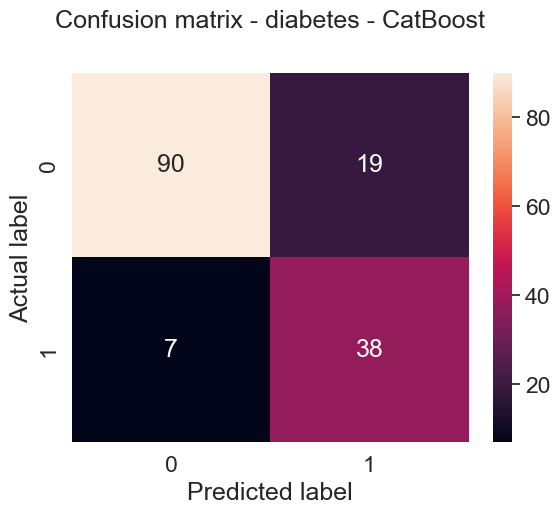

In [30]:
Y_pred = clf.predict(X_test_diabetes)
confusion_mat(Y_pred, Y_test_diabetes,"diabetes - CatBoost")

## Vlagun_phys

### AdaBoost

In [40]:
clf = AdaBoostClassifier(n_estimators=100, random_state=1)
clf.fit(X_train_vlagun_phys, Y_train_vlagun_phys)

train_predicted = clf.predict(X_train_vlagun_phys)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_phys)

test_predicted = clf.predict(X_test_vlagun_phys)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_phys)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 1.0000
Test Accuracy of the result is: 0.8750


### Plot the confusion matrix

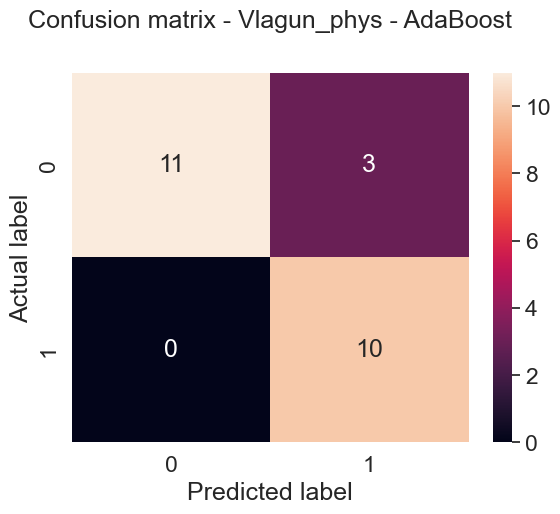

In [41]:
Y_pred = clf.predict(X_test_vlagun_phys)
confusion_mat(Y_pred, Y_test_vlagun_phys, "Vlagun_phys - AdaBoost")

## GradientBoost

In [42]:
clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_vlagun_phys, Y_train_vlagun_phys)

train_predicted = clf.predict(X_train_vlagun_phys)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_phys)

test_predicted = clf.predict(X_test_vlagun_phys)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_phys)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 1.0000
Test Accuracy of the result is: 0.7083


### Plot the confusion matrix

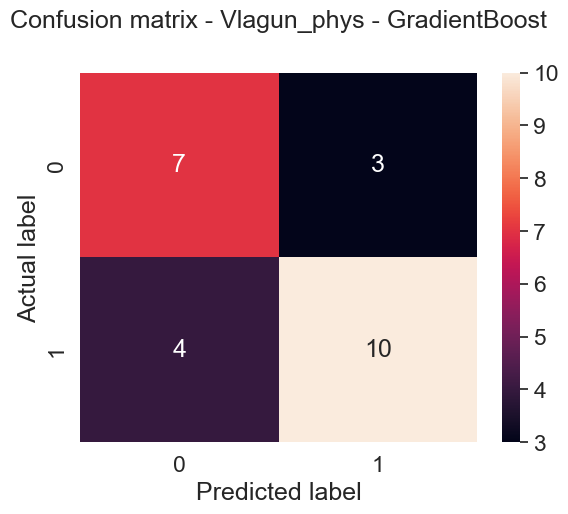

In [43]:
Y_pred = clf.predict(X_test_vlagun_phys)
confusion_mat(Y_pred, Y_test_vlagun_phys, "Vlagun_phys - GradientBoost")

### XGBoost

In [44]:
clf = XGBClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_vlagun_phys, Y_train_vlagun_phys)

train_predicted = clf.predict(X_train_vlagun_phys)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_phys)

test_predicted = clf.predict(X_test_vlagun_phys)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_phys)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 1.0000
Test Accuracy of the result is: 0.8333


### Plot the confusion matrix

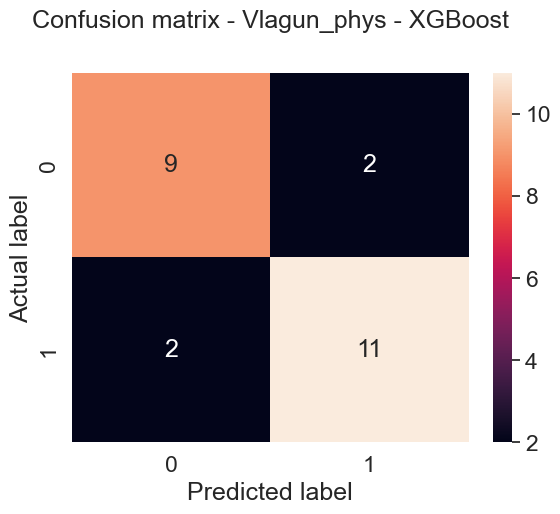

In [45]:
Y_pred = clf.predict(X_test_vlagun_phys)
confusion_mat(Y_pred, Y_test_vlagun_phys, "Vlagun_phys - XGBoost")

### Light GBM

In [46]:
clf = lgb.LGBMClassifier()
clf.fit(X_train_vlagun_phys, Y_train_vlagun_phys)

train_predicted = clf.predict(X_train_vlagun_phys)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_phys)

test_predicted = clf.predict(X_test_vlagun_phys)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_phys)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

[LightGBM] [Info] Number of positive: 43, number of negative: 53
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447917 -> initscore=-0.209092
[LightGBM] [Info] Start training from score -0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Plot the confusion matrix

C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


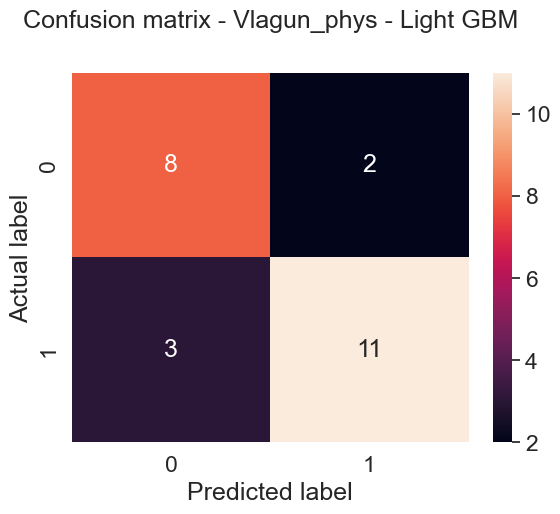

In [47]:
Y_pred = clf.predict(X_test_vlagun_phys)
confusion_mat(Y_pred, Y_test_vlagun_phys, "Vlagun_phys - Light GBM")

### CatBoost

In [48]:
clf = CatBoostClassifier(iterations=100)
clf.fit(X_train_vlagun_phys, Y_train_vlagun_phys)

train_predicted = clf.predict(X_train_vlagun_phys)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_phys)

test_predicted = clf.predict(X_test_vlagun_phys)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_phys)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Learning rate set to 0.031287
0:	learn: 0.6824059	total: 1.54ms	remaining: 153ms
1:	learn: 0.6743449	total: 3.17ms	remaining: 156ms
2:	learn: 0.6665073	total: 4.33ms	remaining: 140ms
3:	learn: 0.6584623	total: 5.34ms	remaining: 128ms
4:	learn: 0.6494479	total: 6.37ms	remaining: 121ms
5:	learn: 0.6424623	total: 7.43ms	remaining: 116ms
6:	learn: 0.6328425	total: 8.64ms	remaining: 115ms
7:	learn: 0.6241480	total: 9.75ms	remaining: 112ms
8:	learn: 0.6170498	total: 10.8ms	remaining: 110ms
9:	learn: 0.6087089	total: 11.9ms	remaining: 107ms
10:	learn: 0.6035711	total: 13.2ms	remaining: 107ms
11:	learn: 0.5969439	total: 14.6ms	remaining: 107ms
12:	learn: 0.5882663	total: 16ms	remaining: 107ms
13:	learn: 0.5824214	total: 32.8ms	remaining: 202ms
14:	learn: 0.5753882	total: 34.6ms	remaining: 196ms
15:	learn: 0.5667717	total: 36.4ms	remaining: 191ms
16:	learn: 0.5606056	total: 37.8ms	remaining: 185ms
17:	learn: 0.5540462	total: 39.2ms	remaining: 179ms
18:	learn: 0.5489253	total: 40.3ms	remaining: 

### Plot the confusion matrix

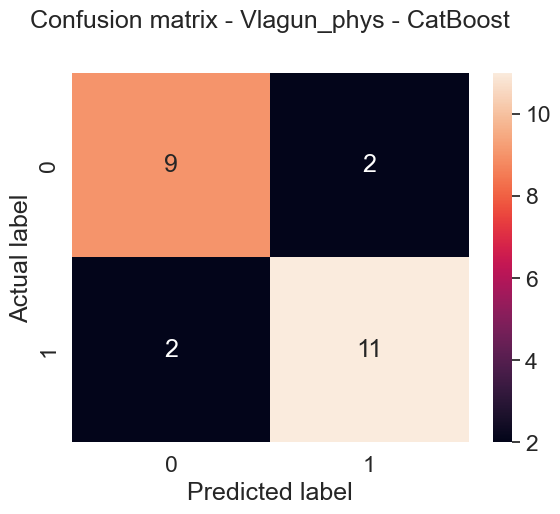

In [49]:
Y_pred = clf.predict(X_test_vlagun_phys)
confusion_mat(Y_pred, Y_test_vlagun_phys, "Vlagun_phys - CatBoost")

## Vlagun_total

### AdaBoost

In [58]:
clf = AdaBoostClassifier(n_estimators=100, random_state=1)
clf.fit(X_train_vlagun_total, Y_train_vlagun_total)

train_predicted = clf.predict(X_train_vlagun_total)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_total)

test_predicted = clf.predict(X_test_vlagun_total)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_total)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 1.0000
Test Accuracy of the result is: 0.7097


### Plot the confusion matrix

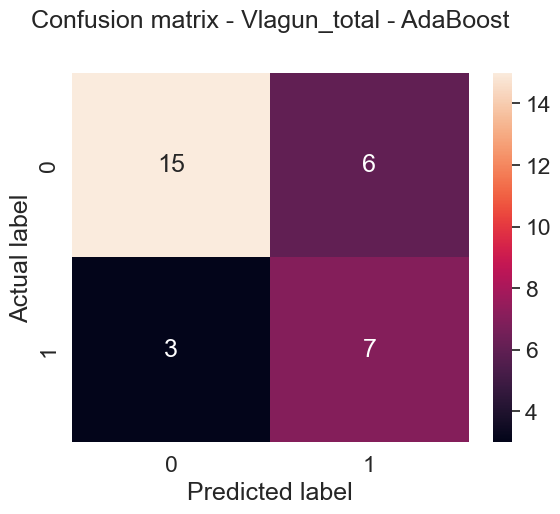

In [60]:
Y_pred = clf.predict(X_test_vlagun_total)
confusion_mat(Y_pred, Y_test_vlagun_total, "Vlagun_total - AdaBoost")

### GradientBoosting

In [61]:
clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_vlagun_total, Y_train_vlagun_total)

train_predicted = clf.predict(X_train_vlagun_total)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_total)

test_predicted = clf.predict(X_test_vlagun_total)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_total)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 1.0000
Test Accuracy of the result is: 0.6452


### Plot the confusion matrix

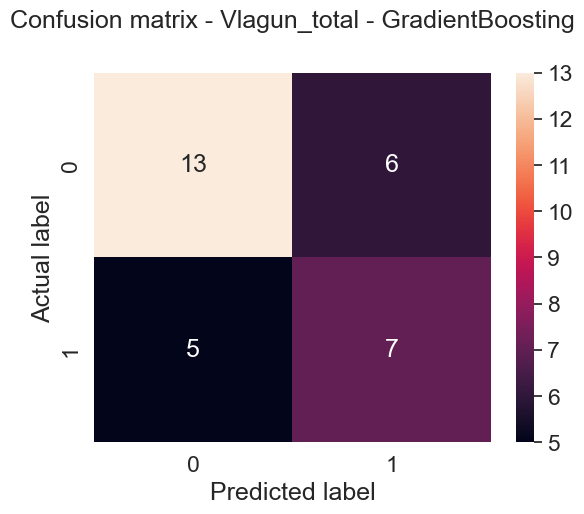

In [62]:
Y_pred = clf.predict(X_test_vlagun_total)
confusion_mat(Y_pred, Y_test_vlagun_total, "Vlagun_total - GradientBoosting")

### XGBoost

In [63]:
clf = XGBClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_vlagun_total, Y_train_vlagun_total)

train_predicted = clf.predict(X_train_vlagun_total)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_total)

test_predicted = clf.predict(X_test_vlagun_total)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_total)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Train Accuracy of the result is: 1.0000
Test Accuracy of the result is: 0.6129


### Plot the confusion matrix

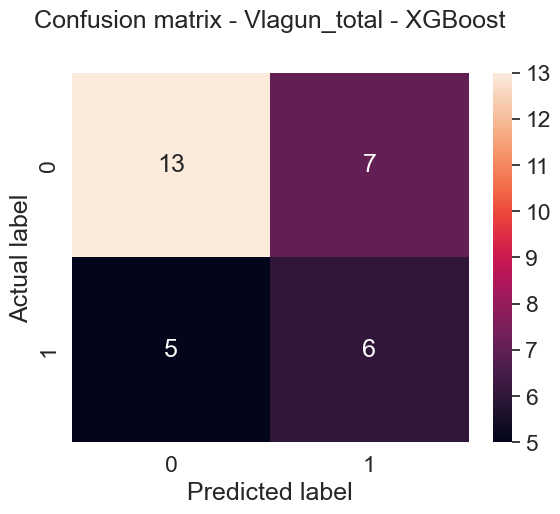

In [64]:
Y_pred = clf.predict(X_test_vlagun_total)
confusion_mat(Y_pred, Y_test_vlagun_total, "Vlagun_total - XGBoost")

### Light GBM

In [65]:
clf = lgb.LGBMClassifier()
clf.fit(X_train_vlagun_total, Y_train_vlagun_total)

train_predicted = clf.predict(X_train_vlagun_total)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_total)

test_predicted = clf.predict(X_test_vlagun_total)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_total)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

[LightGBM] [Info] Number of positive: 52, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419355 -> initscore=-0.325422
[LightGBM] [Info] Start training from score -0.325422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Plot the confusion matrix

C:\Users\Adam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


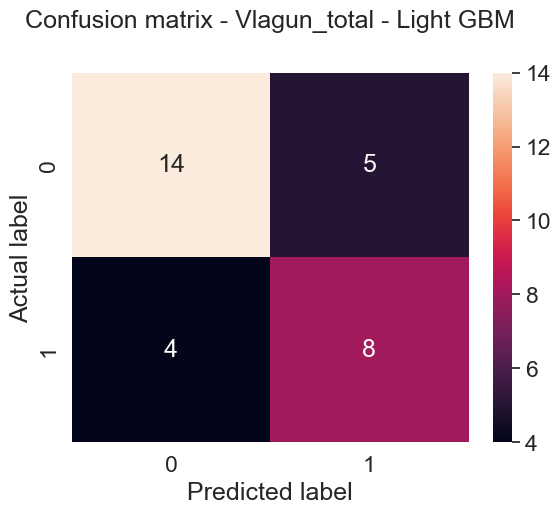

In [66]:
Y_pred = clf.predict(X_test_vlagun_total)
confusion_mat(Y_pred, Y_test_vlagun_total, "Vlagun_total - Light GBM")

### CatBoost

In [67]:
clf = CatBoostClassifier(iterations=100)
clf.fit(X_train_vlagun_total, Y_train_vlagun_total)

train_predicted = clf.predict(X_train_vlagun_total)
train_accuracy = np.mean(train_predicted == Y_train_vlagun_total)

test_predicted = clf.predict(X_test_vlagun_total)
test_accuracy = np.mean(test_predicted == Y_test_vlagun_total)

print(f'Train Accuracy of the result is: {train_accuracy:.4f}\n'
      f'Test Accuracy of the result is: {test_accuracy:.4f}')

Learning rate set to 0.0349
0:	learn: 0.6814552	total: 7.54ms	remaining: 747ms
1:	learn: 0.6595060	total: 11.8ms	remaining: 578ms
2:	learn: 0.6413539	total: 16.4ms	remaining: 531ms
3:	learn: 0.6232864	total: 20.7ms	remaining: 496ms
4:	learn: 0.6129152	total: 25.1ms	remaining: 476ms
5:	learn: 0.5975624	total: 29.1ms	remaining: 456ms
6:	learn: 0.5860966	total: 33.4ms	remaining: 443ms
7:	learn: 0.5711181	total: 37.5ms	remaining: 431ms
8:	learn: 0.5591552	total: 41.9ms	remaining: 424ms
9:	learn: 0.5449902	total: 51.7ms	remaining: 466ms
10:	learn: 0.5289097	total: 66.9ms	remaining: 542ms
11:	learn: 0.5159394	total: 75.5ms	remaining: 553ms
12:	learn: 0.5044167	total: 92ms	remaining: 616ms
13:	learn: 0.4944836	total: 103ms	remaining: 631ms
14:	learn: 0.4833197	total: 112ms	remaining: 633ms
15:	learn: 0.4736131	total: 120ms	remaining: 631ms
16:	learn: 0.4632658	total: 132ms	remaining: 647ms
17:	learn: 0.4515765	total: 147ms	remaining: 670ms
18:	learn: 0.4400974	total: 158ms	remaining: 674ms
19

### Plot the confusion matrix

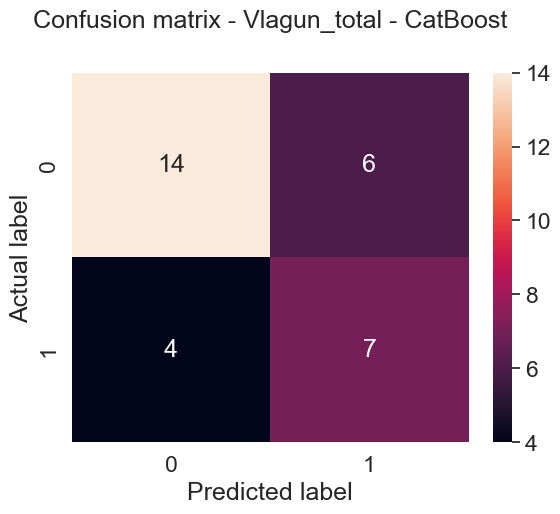

In [70]:
Y_pred = clf.predict(X_test_vlagun_total)
confusion_mat(Y_pred, Y_test_vlagun_total, "Vlagun_total - CatBoost")

## Algorithms comparison
| Dataset                  | AdaBoost Accuracy | Gradient Boosting Accuracy | XGBoost Accuracy | Light GBM Accuracy | CatBoost Accuracy|
|--------------------------|-------------------|----------------------------|------------------|-------------------|-------------------|
| **diabetes (train)**     | 0.7899            | 0.9218                     | 1.0000           | 1.0000            | 0.8485            |
| **diabetes (test)**      | 0.7922            | 0.7857                     | 0.7532           | 0.7403            | 0.8312            |
| **vlagun_phys (train)**  | 1.0000            | 1.0000                     | 1.0000           | 1.0000            | 0.9896            |
| **vlagun_phys (test)**   | 0.8750            | 0.7083                     | 0.8333           | 0.7917            | 0.8333            |
| **vlagun_total (train)** | 1.0000            | 1.0000                     | 1.0000           | 1.0000            | 1.0000            |
| **vlagun_total (test)**  | 0.7097            | 0.6452                     | 0.6129           | 0.7097            | 0.6774            |